In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, optimize
import functools, operator

%matplotlib inline

from math import ceil
from migen import *
from migen.fhdl import verilog

In [ ]:
# http://home.mit.bme.hu/~kollar/papers/cic.pdf

In [10]:
def stream(width):
    return Record([
        ("data", width, DIR_M_TO_S),
        ("stb", 1, DIR_M_TO_S),
        ("ack", 1, DIR_M_TO_S),
    ])


def source(stream, i):
    for ti, ii in i:
        assert ti > 0
        for _ in range(ti - 1):
            yield
        yield stream.data.eq(ii)
        yield stream.stb.eq(1)
        yield
        while not (yield stream.ack):
            #print(ti, "dly")
            yield
        yield stream.stb.eq(0)


#@passive
def sink(stream, o, max):
    yield stream.ack.eq(1)
    t = 0
    
    while True:
        while not (yield stream.stb):
            t += 1
            yield
        d = yield stream.data
        o.append((t, d))
        if len(o) == max:
            break
        t = 1
        yield
    yield stream.ack.eq(0)
    

class Upsampler(Module):
    def __init__(self, r, width):
        self.i = stream(width)
        self.o = stream(width)
        self.r = Signal(max=r, reset=r - 1)

        i = Signal(max=r)
        i_done = Signal()
        self.comb += [
            i_done.eq(i == 0),
            self.i.ack.eq(i_done & self.o.ack),
            If(i_done,
                self.o.data.eq(self.i.data),
            ),
            self.o.stb.eq(~i_done | self.i.stb),
        ]
        self.sync += [
            If(self.o.ack & self.o.stb & ~i_done,
                i.eq(i - 1)
            ),
            If(self.i.ack & self.i.stb,
                i.eq(self.r)
            ),
        ]


class Downsampler(Module):
    def __init__(self, r, width):
        self.i = stream(width)
        self.o = stream(width)
        self.r = Signal(max=r, reset=r - 1)

        i = Signal(max=r)
        i_done = Signal()
        self.comb += [
            i_done.eq(i == 0),
            self.i.ack.eq(~i_done | self.o.ack),
            self.o.data.eq(self.i.data),
            self.o.stb.eq(i_done & self.i.stb),
        ]
        self.sync += [
            If(self.i.ack & self.i.stb & ~i_done,
                i.eq(i - 1)
            ),
            If(self.o.ack & self.o.stb,
                i.eq(self.r)
            ),
        ]

        
class Register(Module):
    def __init__(self, width):
        self.i = stream(width)
        self.o = stream(width)
        self.o.data.reset_less = True

        self.comb += [
            self.i.ack.eq(~self.o.stb | self.o.ack),
        ]
        self.sync += [
            If(self.o.ack,
                self.o.stb.eq(0),
            ),
            If(self.i.ack & self.i.stb,
                self.o.data.eq(self.i.data),
                self.o.stb.eq(1)
            )
        ]


class CIC(Module):
    def __init__(self, r, m, n, width):
        if isinstance(width, tuple):
            width = width[0]
        self.gain = (r*m)**n/r
        self.rate = Signal(max=abs(r), reset=abs(r) - 1)

        g = -(1 << width - 1)
        w = lambda g: (bits_for(ceil(g)), True)
        self.i = stream(w(g))
        self.o = stream(w(g*self.gain))

        self.i_stall = Signal()
        self.o_drop = Signal()

        self.comb += [
            self.i_stall.eq(~self.i.ack & self.i.stb)
        ]
        
        x, en = self.i.data, self.i.stb
        if r > 0:
            i = Signal(max=r)
            self.comb += [
                self.i.ack.eq(i == 0),
            ]
            self.sync += [
                If(~self.i.ack,
                    i.eq(i - 1),
                ),
                If(self.i.stb,
                   i.eq(self.rate - 1),
                ),
            ]
            if False:
                for i in range(n):
                    g *= 2
                    x, en = self.make_comb(x, en, w(g), m)
            else:
                g *= 2**n
                x, en = self.make_itercomb(x, en, w(g), n, m)
            self.submodules.r = Upsampler(abs(r), w(g))
            g *= 1/r
            self.comb += [
                self.r.r.eq(self.rate),
                self.r.i.data.eq(x),
                self.r.i.stb.eq(en),
                self.r.o.ack.eq(1),
            ]
            x, en = self.r.o.data, self.r.o.stb
            for i in range(n):
                g *= r*m/2
                x, en = self.make_integrator(x, en, w(g))
        else:
            self.comb += self.i.ack.eq(1)
            g *= (r*m)**n
            for i in range(n):
                x, en = self.make_integrator(x, en, w(g))
            self.submodules.r = Downsampler(abs(r), w(g))
            self.comb += [
                self.r.r.eq(self.rate),
                self.r.i.data.eq(x),
                self.r.i.stb.eq(en),
                self.r.o.ack.eq(1),
            ]
            x, en = self.r.o.data, self.r.o.stb
            for i in range(n):
                x, en = self.make_comb(x, en, w(g), m)
        self.o.data.reset_less = True
        self.sync += [
            self.o.data.eq(x),
            self.o.stb.eq(en),
            self.o_drop.eq(self.o.stb & ~self.o.ack & en),
        ]

    def make_comb(self, i, en, width, m=1):
        i0 = i
        for _ in range(m):
            i1, i0 = i0, Signal.like(i0)
            self.sync += [
                If(en,
                    i0.eq(i1),
                )
            ]
        comb = Signal(width, reset_less=True)
        comb_en = Signal()
        self.sync += [
            comb.eq(i - i0),
            comb_en.eq(en),
        ]
        return comb, comb_en

    def make_itercomb(self, i, en, width, n, m=1):
        if m != 1:
            raise NotImplemented()
        mem = Memory(width=width[0], depth=bits_for(n))
        memp = mem.get_port(write_capable=True, mode=READ_FIRST)
        self.specials += mem, memp
        j = Signal(max=n)
        i0 = Signal(width, reset_less=True)
        comb0 = Signal(width)
        comb = Signal(width, reset_less=True)
        done = Signal()
        self.comb += done.eq(j == n - 1)
        self.sync += [
            If(~done,
               j.eq(j - 1)
            ),
            If(en,
               j.eq(n - 1)
            ),
            i0.eq(memp.dat_w)
        ]
        self.comb += [
            comb0.eq(i0 - memp.dat_r),
            memp.dat_w.eq(Mux(en, i, comb)),
        ]
        return comb, comb_en

    
    def make_integrator(self, i, en, width):
        integrator = Signal(width)
        integrator_en = Signal()
        self.sync += [
            If(en,
                integrator.eq(integrator + i),
            ),
            integrator_en.eq(en),
        ]
        return integrator, integrator_en

In [7]:
Memory(19, 3).get_port(write_capable=True, mode=READ_FIRST)

In [5]:
r = 3
f = Upsampler(r, 8)
i = [(4, 1), (3, 2), (3, 3), (10, 4)]
o = []

with Simulator(f, [source(f.i, i), sink(f.o, o, r*len(i))]) as sim:
    sim.run()
print(o)

[(4, 1), (1, 0), (1, 0), (1, 2), (1, 0), (1, 0), (1, 3), (1, 0), (1, 0), (8, 4), (1, 0), (1, 0)]


In [6]:
r = 3
f = Downsampler(r, 8)
i = [(4, 1), (1, 2), (1, 3), (1, 4), (1, 5), (3, 6), (10, 7), (1, 8), (1, 9)]
o = []

with Simulator(f, [source(f.i, i), sink(f.o, o, len(i)//r)]) as sim:
    sim.run()
print(o)

[(4, 1), (3, 4), (14, 7)]


In [7]:
f = Register(8)
i = [(4, 1), (3, 2), (3, 3), (10, 4)]
o = []

with Simulator(f, [source(f.i, i), sink(f.o, o, len(i))]) as sim:
    sim.run()
print(o)

[(5, 1), (3, 2), (3, 3), (10, 4)]


In [8]:
2**4*(4*1)**4/4

1024.0

In [11]:
r = 4
f = CIC(r, 1, 5, (8, True))
i = [(r, 127), (r, 127), (r, 127), (r, 127), (r, 0), (r, 0), (3*r, 0)]
o = []

with Simulator(f, [source(f.i, i), sink(f.o, o, r*len(i))]) as sim:
    sim.run()
print(o, f.gain*i[0][1])

[(11, 127), (1, 635), (1, 1905), (1, 4445), (1, 8890), (1, 16002), (1, 26670), (1, -23626), (1, 30097), (1, 25269), (1, 12439), (1, 25899), (1, -31004), (1, -25420), (1, -20980), (1, -15652), (1, -7404), (1, 5796), (1, -6788), (1, 6028), (1, 13508), (1, 17684), (1, 20588), (1, 24252), (9, 30708), (1, -23548), (1, 27356), (1, -27540)] 32512.0


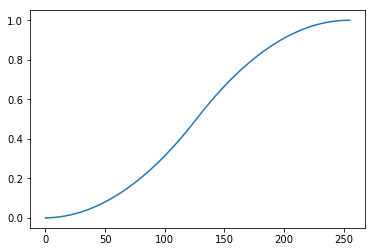

In [10]:
r = 128
f = CIC(r, 1, 3, (16, True))
i = [(r, 1)]*2 #+ [(r, 0)]*r
o = []
with Simulator(f, [source(f.i, i), sink(f.o, o, r*len(i))]) as sim:
    sim.run()
o = np.array([_[1] for _ in o])/f.gain
plt.plot(o)
#plt.psd(o);

In [11]:
f = CIC(512, 1, 4, 8)
print(verilog.convert(f, ios={f.i.ack, f.i.stb, f.i.data, f.i_stall, f.o.ack, f.o.stb, f.o.data, f.o_drop}))

/* Machine-generated using Migen */
module top(
	input signed [7:0] data,
	input stb,
	output ack,
	output reg signed [34:0] data_1,
	output reg stb_1,
	input ack_1,
	output i_stall,
	output reg o_drop,
	input sys_clk,
	input sys_rst
);

reg [8:0] rate = 9'd511;
reg [8:0] i0 = 9'd0;
reg signed [7:0] cic0 = 8'sd0;
reg signed [8:0] cic_comb0 = 9'sd0;
reg cic_comb_en0 = 1'd0;
reg signed [8:0] cic1 = 9'sd0;
reg signed [9:0] cic_comb1 = 10'sd0;
reg cic_comb_en1 = 1'd0;
reg signed [9:0] cic2 = 10'sd0;
reg signed [10:0] cic_comb2 = 11'sd0;
reg cic_comb_en2 = 1'd0;
reg signed [10:0] cic3 = 11'sd0;
reg signed [11:0] cic_comb3 = 12'sd0;
reg cic_comb_en3 = 1'd0;
wire signed [11:0] i_data1;
wire i_stb1;
wire i_ack1;
reg signed [11:0] o_data1;
wire o_stb1;
wire o_ack1;
wire [8:0] r;
reg [8:0] i1 = 9'd0;
wire i_done;
reg signed [10:0] cic_integrator0 = 11'sd0;
reg cic_integrator_en0 = 1'd0;
reg signed [18:0] cic_integrator1 = 19'sd0;
reg cic_integrator_en1 = 1'd0;
reg signed [26:0] cic_integrator2 =

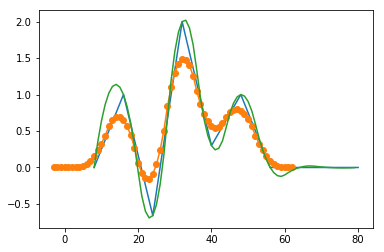

In [97]:
r = 8

x = np.array([0, 1., -.66, 2, .3, 1] + [0]*4)
x = x.repeat(1)
dt = np.ones(len(x), np.int32)*r
t = dt.cumsum()

# r = 1 << bits_for(int(max(dt)))
f = CIC(r, 1, 3, (16, True))
i = [(int(dti), int(xi*(1 << 12))) for dti, xi in zip(dt, x)]
o = []

def rate_setter(dut, dt, dly=1):
    for i in range(dly):
        yield
    for dti in dt[1:]:
        for i in range(dti):
            yield
        yield dut.rate.eq(int(dti - 1))

# rate_setter(f, dt), 
try:
    with Simulator(f, [source(f.i, i), passive(sink)(f.o, o, None)]) as sim:
        sim.run()
except KeyboardInterrupt:
    pass
ot, ox = np.array(o).T
ot = ot.cumsum() - 18
ox = ox/f.gain/(1 << 12)

fig, ax = plt.subplots()
ax.plot(t, x)
ax.plot(ot, ox, "o-")

from artiq.wavesynth import coefficients
ms = coefficients.UnivariateMultiSpline(t, x[None, :], order=3)
st = np.arange((len(t) - 1)*r) + r
sx = ms(st)[0, 0]
ax.plot(st, sx)

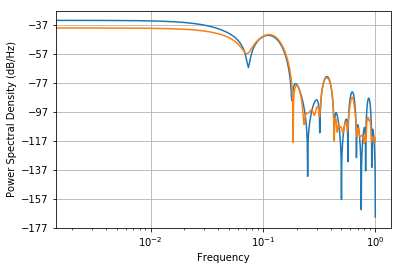

In [98]:
fig, ax = plt.subplots()
n = 1 << 10
ax.set_xscale("log")
ax.psd(ox, NFFT=n)
ax.psd(sx, NFFT=n);

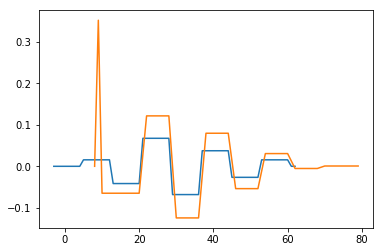

In [99]:
plt.plot(ot, np.ediff1d(np.ediff1d(ox, to_begin=0), to_begin=0))
plt.plot(st, np.ediff1d(np.ediff1d(sx, to_begin=0), to_begin=0))